In [124]:
import torch
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import optim
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [125]:
x_data = pd.read_csv("data/x_Swedbank_A_70_p.csv", sep=";", usecols = [i for i in range(70)])

In [126]:
y_data_ = pd.read_csv("data/y_Swedbank_A_70.csv", sep=";")

In [127]:
x_data.head() 

,Swedbank_A-price-0,Swedbank_A-price-1,Swedbank_A-price-2,Swedbank_A-price-3,Swedbank_A-price-4,Swedbank_A-price-5,Swedbank_A-price-6,Swedbank_A-price-7,Swedbank_A-price-8,Swedbank_A-price-9,...,Swedbank_A-price-60,Swedbank_A-price-61,Swedbank_A-price-62,Swedbank_A-price-63,Swedbank_A-price-64,Swedbank_A-price-65,Swedbank_A-price-66,Swedbank_A-price-67,Swedbank_A-price-68,Swedbank_A-price-69
0,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,...,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14
1,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,...,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.20
2,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,...,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.20
3,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,...,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.20
4,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,...,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.20


In [128]:
y_data_.head()

,15s,15sa,15ud,30s,30sa,30ud,45s,45sa,45ud,60s,...,180s,180sa,180ud,300s,300sa,300ud,600s,600sa,600ud,ts
0,145.14,145.0,0,145.14,145.070000,0,145.24,145.24,1,145.32,...,145.16,145.168,1,145.34,145.263,1,145.26,145.238333,1,1604390404
1,145.14,145.0,-1,145.00,145.046667,-1,145.24,145.24,1,145.32,...,145.16,145.168,-1,145.34,145.263,1,145.26,145.238333,1,1604390405
2,145.14,145.0,-1,145.00,145.046667,-1,145.24,145.24,1,145.32,...,145.16,145.168,-1,145.34,145.263,1,145.26,145.238333,1,1604390406
3,145.14,145.0,-1,145.00,145.046667,-1,145.24,145.24,1,145.32,...,145.16,145.168,-1,145.34,145.263,1,145.26,145.238333,1,1604390407
4,145.14,145.0,-1,145.00,145.046667,-1,145.24,145.24,1,145.32,...,145.16,145.168,-1,145.34,145.263,1,145.26,145.238333,1,1604390408


In [129]:
x_data.shape

(1809209, 70)

In [152]:
y_data = y_data_[:-2]
y_data = y_data["180sa"] #300s - 5min exakt price
y_data.shape

(1809208,)

In [153]:
def splitData(xs, ys, trainRatio):
    t = round(len(xs)*trainRatio)
    
    train_data_x = torch.tensor(xs[:t].values, dtype=torch.float32)
    train_data_y = torch.tensor(ys[:t].values, dtype=torch.float32)
    
    d = round(len(xs[t:])/2)
    
    dev_data_x = torch.tensor(xs[t:][:d].values, dtype=torch.float32)
    dev_data_y = torch.tensor(ys[t:][:d].values, dtype=torch.float32)
    
    test_data_x = torch.tensor(xs[t:][d:].values, dtype=torch.float32)
    test_data_y = torch.tensor(ys[t:][d:].values, dtype=torch.float32)
    
    #print(test_data_y.shape)
    
    return TensorDataset(train_data_x, train_data_y), TensorDataset(dev_data_x, dev_data_y), list(zip(test_data_x, test_data_y))

In [154]:
train_data, dev_data, test_data = splitData(x_data, y_data, 0.8)

In [155]:
input_size=70
batch_size=128
nbr_epochs=20

In [156]:
#compute_unit = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device('cuda:0')
#compute_unit = "cpu"

In [157]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

In [158]:
class StockModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 30).type(dtype)
        #torch.nn.init.normal_(self.fc1.weight, mean=0, std=1.0)
        self.fc2 = nn.Linear(30, 5).type(dtype)
        self.fc3 = nn.Linear(5, 30).type(dtype)
        self.fc4 = nn.Linear(30, 10).type(dtype)
        #torch.nn.init.normal_(self.fc2.weight, mean=0, std=1.0)
        self.fc5 = nn.Linear(10, 1).type(dtype)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return F.relu(self.fc5(x))

model = StockModel(input_size)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [159]:
def evaluate_model(data, model, loss_fn):
    losses = []
    predictions = []
    with torch.no_grad():
        for x, y in data:
            y = y.squeeze().type(dtype)
            x = x.squeeze().type(dtype)
            pred = model(x)
            loss = loss_fn(pred, y)
            losses.append(loss.item())
            predictions.extend(pred.tolist())
        avg_loss = sum(losses)/len(losses)    
    
    return avg_loss, predictions

In [160]:
def train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, epochrange, batchsize):
    for epoch in range(epochrange):
        losses = []
        n_correct = 0
        for x, y in train_data_loader:
            y = y.squeeze().type(dtype)
            x = x.squeeze().type(dtype)
            
            pred = model(x)
            loss = loss_fn(pred, y)

            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()    

        # Compute accuracy and loss in the entire training set
        train_avg_loss = sum(losses)/len(losses)    
        
        dev_avg_loss,_ = evaluate_model(dev_data_loader, model, loss_fn)
        
        # Display metrics
        display_str = 'Epoch {} '
        display_str += '\tLoss: {:.3f} '
        display_str += '\tLoss (val): {:.3f}'
        print(display_str.format(epoch, train_avg_loss, dev_avg_loss))

In [161]:
train_data_loader = DataLoader(train_data, batch_size=batch_size)
dev_data_loader = DataLoader(dev_data, batch_size=batch_size)

In [162]:
model = model.to(device)
train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, nbr_epochs, batch_size)

Epoch 0 	Loss: 7.731 	Loss (val): 2.198
Epoch 1 	Loss: 2.344 	Loss (val): 1.083
Epoch 2 	Loss: 0.916 	Loss (val): 0.060
Epoch 3 	Loss: 0.781 	Loss (val): 0.085
Epoch 4 	Loss: 0.730 	Loss (val): 0.119
Epoch 5 	Loss: 0.635 	Loss (val): 0.301
Epoch 6 	Loss: 0.525 	Loss (val): 0.233
Epoch 7 	Loss: 0.500 	Loss (val): 0.218
Epoch 8 	Loss: 0.478 	Loss (val): 0.098
Epoch 9 	Loss: 0.434 	Loss (val): 0.164
Epoch 10 	Loss: 0.377 	Loss (val): 0.213
Epoch 11 	Loss: 0.371 	Loss (val): 0.215
Epoch 12 	Loss: 0.369 	Loss (val): 0.222
Epoch 13 	Loss: 0.367 	Loss (val): 0.232
Epoch 14 	Loss: 0.365 	Loss (val): 0.243
Epoch 15 	Loss: 0.363 	Loss (val): 0.257
Epoch 16 	Loss: 0.361 	Loss (val): 0.273
Epoch 17 	Loss: 0.359 	Loss (val): 0.289
Epoch 18 	Loss: 0.358 	Loss (val): 0.307
Epoch 19 	Loss: 0.356 	Loss (val): 0.326


In [163]:
_, preds = evaluate_model(test_data, model, loss_fn)

/home/oscar/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


162.8087921142578


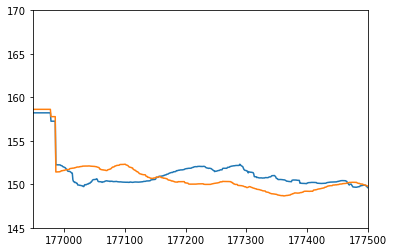

In [166]:
y_data_borpi = list(zip(*test_data))
print(preds[0])
items_plot = [y_data_borpi[1][t] for t in range(len(y_data_borpi[1]))]
plt.plot(list(range(len(preds))), preds)
plt.plot(list(range(len(items_plot))), items_plot)
axes = plt.gca()
axes.set_ylim([145,170])
#axes.set_xlim([125000,129000])
axes.set_xlim([176950,177500])
#axes.set_xlim([23800,24100])
plt.show()